In [1]:
# 이제는 단순히 긍정, 부정이아니고 AI가 문장을 해석해야한다

https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr 참조

In [2]:
# p262 LSTM을 이용한 로이터 뉴스 카테고리 분류하기
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# 로이터 데이터 가져오기
# 전체 데이터 중 20%를 테스트 데이터로 사용
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

2110848/2110848 [==============================] - 0s 0us/step


In [6]:
# 전체 카테고리 갯수
category=np.max(y_train) + 1
print('종류:', category)
print('Train data', len(X_train))
print('Test data', len(X_test))

종류: 46
Train data 8982
Test data 2246


In [9]:
print(len(X_train[0]))

87


In [10]:
# 패딩// 단어마다 기사의 길이가 다르므로
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

In [11]:
# 타겟값을 46차원의 원핫 인코딩 >> to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
model=models.Sequential()
# 임베딩에서 단어의 종류갯수 입력(1000차원을 100차원으로 변경하기) // 출력이 100차원이됨
model.add(layers.Embedding(1000, 100))
# 출력이 100인 LSTM 
model.add(layers.LSTM(100, activation='tanh'))
# 다중분류이기에 softmax

model.add(layers.Dense(46, activation='softmax'))
model.summary()

# 입력값 1000 * 출력값 100 = 100000 
# (output + input) 이 입력차원 (h, Xt) 
# 컬럼수는 output, bias 는 output
# ((100 + 100)[input] x 100[output] + 100(bias)) x 4(gate)
# ((출력+입력) x 출력 + 출력) x 게이트 수
# 입력값 100 * 출력값 46 + 46 = 4646

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         100000    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 46)                4646      
                                                                 
Total params: 185,046
Trainable params: 185,046
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping=EarlyStopping(monitor='val_loss', patience=5)

In [14]:
# 학습 데이터를 쪼개서 validation하지말고, X_test, y_test에 별도로 공금
history = model.fit(X_train, y_train, batch_size=20, epochs=200,
                   validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/200
450/450 [==============================] - 22s 44ms/step - loss: 2.1627 - accuracy: 0.4530 - val_loss: 1.8130 - val_accuracy: 0.5294
Epoch 2/200
450/450 [==============================] - 20s 44ms/step - loss: 1.7270 - accuracy: 0.5518 - val_loss: 1.6689 - val_accuracy: 0.5695
Epoch 3/200
450/450 [==============================] - 20s 45ms/step - loss: 1.5947 - accuracy: 0.5858 - val_loss: 1.5693 - val_accuracy: 0.5904
Epoch 4/200
450/450 [==============================] - 20s 45ms/step - loss: 1.4433 - accuracy: 0.6257 - val_loss: 1.4317 - val_accuracy: 0.6407
Epoch 5/200
450/450 [==============================] - 21s 46ms/step - loss: 1.2882 - accuracy: 0.6661 - val_loss: 1.3586 - val_accuracy: 0.6505
Epoch 6/200
450/450 [==============================] - 21s 46ms/step - loss: 1.1598 - accuracy: 0.7003 - val_loss: 1.2529 - val_accuracy: 0.6808
Epoch 7/200
450/450 [==============================] - 21s 46ms/step - loss: 1.0376 - accuracy: 0.7344 - val_loss: 1.1814 - val_ac

In [16]:
print('TEST ACCURACY: %.4f' %(model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 1s 15ms/step - loss: 1.2174 - accuracy: 0.7168
TEST ACCURACY: 0.7168


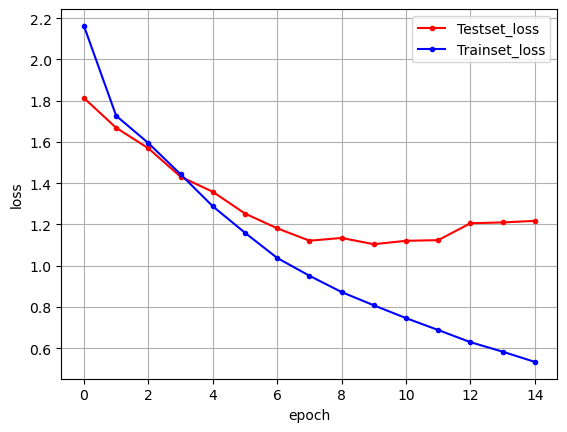

In [17]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()